In [ ]:
Name-Atharva Talegaonkar SID-862467125

In [16]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features.to_numpy()
y = breast_cancer_wisconsin_diagnostic.data.targets.to_numpy()
  
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
Question-1 : K-means clustering
I implemented k-means clustering here using Lyods algorithm using two initilaization methods random and k-means .It measured the performance of 
clustering using silhouette score ,which is used to find the similarity of an object with own cluster when compared to other clusters.I repeated this 
process multiple times to get average performance measure.Lastly , I plotted a graph of k-means clustering using k-means++ and random initialization.
Both the graphs are overlapping each other.

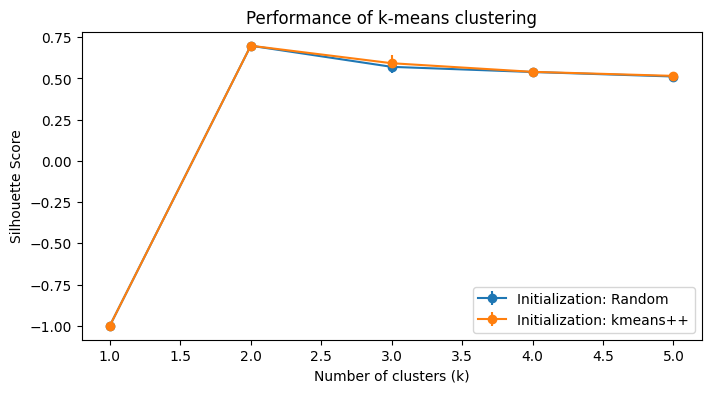

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class K_Means:                                                      #Defined a class for k-means
    def __init__(self, n_clusters, init='Random', max_iter=300):   # This part can be changes to kmeans++ for initialization 
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter

    def fit(self, X):                                        #Defined a fit method for fitting of the model to our data-set.
        if self.init == 'Random':                                 # Initialiaztion method is random , hence it cluster centers are selected randomly
            centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        elif self.init == 'kmeans++':                         #When this initialization method is used, it selects cluster centers using k-means++
            centers = self.k_means_plus_plus_init(X)
        else:
            raise ValueError("Initialization method must be 'Random' or 'kmeans++'.")

        #Implmeneted Llyods algorithm
        for _ in range(self.max_iter):                         
            distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)     #Computed the distance cluster center and a data point.
            labels = np.argmin(distances, axis=1)                               #Assigned data point to their nearest clusters.
            new_centers = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)]) #Updated cluster center by finding mean of points.
            if np.all(centers == new_centers):           # Iteration stopped if cluster center not changes
                break
            centers = new_centers                       #Updated cluster centre to new finded centers.

        self.cluster_centers_ = centers            #Stored final cluster centers and labels also.
        self.labels_ = labels                   
 
   #Implemneted k-means algoritm from scratch
    def k_means_plus_plus_init(self, X):             
        centers = [X[np.random.randint(X.shape[0])]]
        while len(centers) < self.n_clusters:
            distances = np.array([min([np.linalg.norm(x - c) for c in centers]) for x in X])
            Probabilities = distances / distances.sum()
            Cumulative_Probabilities = Probabilities.cumsum()
            r = np.random.rand()
            for j, p in enumerate(Cumulative_Probabilities):
                if r < p:
                    i = j
                    break
            centers.append(X[i])
        return np.array(centers)

#Computed silhouette scores for clustering .        
def silhouette_score(X, labels):
    distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
    a = np.array([np.mean(distances[i, labels == labels[i]]) for i in range(len(X))])  #Calculated a which is the distance between points in same cluster
    b = []                              #Calculated b which is mean distance between points in nearest but different cluster
    for i in range(len(X)):
        Distances_from_other_clusters = [np.mean(distances[i, labels == j]) for j in set(labels) if j != labels[i]]
        if Distances_from_other_clusters:             
            b.append(np.min(Distances_from_other_clusters))               
        else:
            b.append(0)  # When no other clusters nearby setted b to 0
    b = np.array(b)
    s = np.where(a == 0, 0, (b - a) / np.maximum(a, b))  # Handled division by 0 for cases where a == 0
    return np.mean(s), np.std(s)    #Calculated  sihoueete score for every point and returned the mean and standard deviation of this scores.



# Defined  different  parameters like number of clusters 
k_range = range(1, 6)
init_methods = ['Random', 'kmeans++']
results = {'Random': [], 'kmeans++': []}     #Initialized a dictionary to store results of both the intializaton methods.

# Performed  clustering for each k and initialization method
for init_method in init_methods:
    for k in k_range:
        silhouette_scores = []
        for _ in range(10):      #Repeated clustering 10 times as mentioned.
            kmeans = K_Means(n_clusters=k, init=init_method)
            kmeans.fit(X)        #Fitted the k-means model and silhouette score for each loop.
            silhouette_score_mean, silhouette_score_std = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(silhouette_score_mean)
        results[init_method].append((np.mean(silhouette_scores), np.std(silhouette_scores))) #Stored the avrega of silhoueete score and standar deviation

# Plotted the graph.
plt.figure(figsize=(8, 4))
for init_method in init_methods:
    means, stds = zip(*results[init_method])
    plt.errorbar(k_range, means, yerr=stds, fmt='-o', label=f'Initialization: {init_method}') #You can see a small error-bar at k=3 .
plt.title('Performance of k-means clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show() 


In [ ]:
Question-2 : Density-based clustering with DBSCAN
Here I implemented the DBSCAN Algorithm on the data-set using different value of Eps .Eps means it is the max distance between 2 points so that 
they can be called as neighbours.Also MinPts was used for evaluating the performance of DBSCAN as a function here.The performance is again measured using
silhouetter score.Finally , I plotted the graph using the standard deviation of the silhouetter scores to show the working of DBSCAN Clustering.

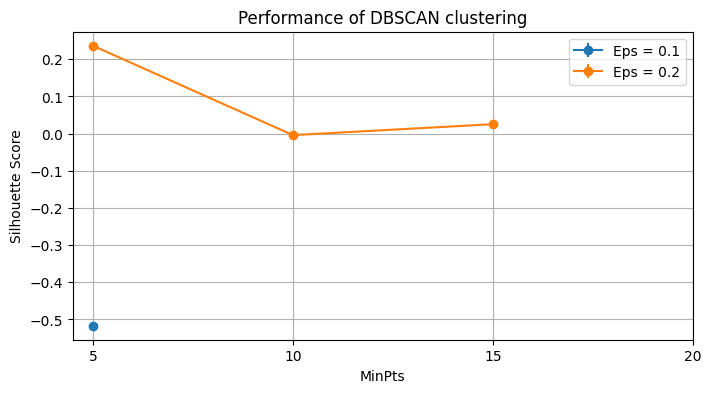

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler  #Imported this library for Data-Preprocessing


# Pre-processed the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Defined a class for DBSCAN clustering
class DBSCAN:
    def __init__(self, Eps, MinPts):    #Intialzer that sets the value of Eps and MinPts
        self.Eps = Eps
        self.MinPts = MinPts

    def fit_predict(self, X):     #Defined a fit function that clustered the data.
        clusters = []             #Defined a set for empty clsuters
        visited = set()           #Defined a set for visited points
        noise = set()            #Defiened a set for noisy points

        for pointing_id, point in enumerate(X):         #Iterated trough every point.
            if pointing_id not in visited:            #If point has been not visited ,marked it as visited and found its negihbours.
                visited.add(pointing_id)
                neighbors = self.Region_Query(X, pointing_id)
                if len(neighbors) < self.MinPts:    #When number of neighbours is less than number of MinPts lablled it as noise.
                    noise.add(pointing_id)           
                else:
                    cluster = self.Expand_of_Cluster(X, pointing_id, neighbors, visited)  #Expanded cluster when above case is not true.
                    clusters.append(cluster)
        return clusters, noise

    def Region_Query(self, X, pointing_id):  #Defined a function which found all points within Eps distance from any point.
        neighbors = []
        for i, point in enumerate(X):
            if np.linalg.norm(point - X[pointing_id]) < self.Eps:  #Calculation of Euclidean Distance.
                neighbors.append(i)
        return neighbors

    def Expand_of_Cluster(self, X, pointing_id, neighbors, visited): #Function to label points as visited or not and then based on the MinPts distance ,add 
        cluster = [pointing_id]                                   # to cluster or lablled as noise.
        for neighboring_id in neighbors:
            if neighboring_id not in visited:
                visited.add(neighboring_id)
                new_neighbors = self.Region_Query(X, neighboring_id)
                if len(new_neighbors) >= self.MinPts:        #Condition to add neighbours to clusters.d
                    neighbors.extend(new_neighbors)
            if neighboring_id not in cluster:                 #Adding of neighbour to cluster if not done already.
                cluster.append(neighboring_id)
        return cluster

# Defined different  parameters like Eps and MinPts value.
MinPts_values = [5, 10, 15, 20]
Eps_values = [0.1, 0.2]
results = {eps: [] for eps in eps_values}

# Performed clustering for each MinPts and Eps combination
for Eps in Eps_values:
    for MinPts in MinPts_values:                   #Loop to go thorugh comibantions of Eps and MinPts
        silhouette_scores = []
        for _ in range(10):  # Ran clustering 10 times with different random initializations
            dbscan = DBSCAN(Eps=Eps, MinPts=MinPts)
            clusters, noise = dbscan.fit_predict(X_scaled)         #Used fit to perform clustering .It is used to identify noise and clusters.
            labels = np.zeros(len(X_scaled), dtype=int)              #Used to store the cluster labels for each point.
            if len(clusters) > 0:  # Ensured at least one cluster is formed
                for cluster_id, cluster in enumerate(clusters):
                    labels[cluster] = cluster_id + 1
                labels[list(noise)] = -1                    #Assigent -1 label to noisy points.
                try:
                    silhouette = silhouette_score(X_scaled, labels)
                    silhouette_scores.append(silhouette)
                except ValueError:
                    # Silhouette score required at least 2 clusters
                    pass
        if silhouette_scores:  # Ensured there are valid silhouette scores
            avg_silhouette = np.mean(silhouette_scores)
            std_silhouette = np.std(silhouette_scores)
            results[Eps].append((MinPts, avg_silhouette, std_silhouette))

# Plotted performance of DBSCAN clustering
plt.figure(figsize=(8, 4))
for Eps, performance in results.items():
    if performance:  # Checked  if there's any valid performance data
        MinPts, avg_silhouette, std_silhouette = zip(*performance)
        plt.errorbar(MinPts, avg_silhouette, yerr=std_silhouette, label=f'Eps = {Eps}', fmt='-o')
plt.title('Performance of DBSCAN clustering')
plt.xlabel('MinPts')
plt.ylabel('Silhouette Score')
plt.xticks(MinPts_values)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Question-3 : Graph-based clustering with Spectral Clustering
Here I implemented a version of Spectral Clustering as mentioned in the research paper. I also implemented the gaussian similarity function as shown
in the reasearch paper.IT basically computes a similartiy matrix which shows the similarity in the matrix.It iterates over all the data points and 
computes their euclidean distances and thus finds the similarity between data-points.The similarity that is found is stored in a matrix.I used silhouette
scoring to evaluate the performance of spectral clustering for different value of K and finally plotted the graph for sigma value of 0.1 , 1 and 10.

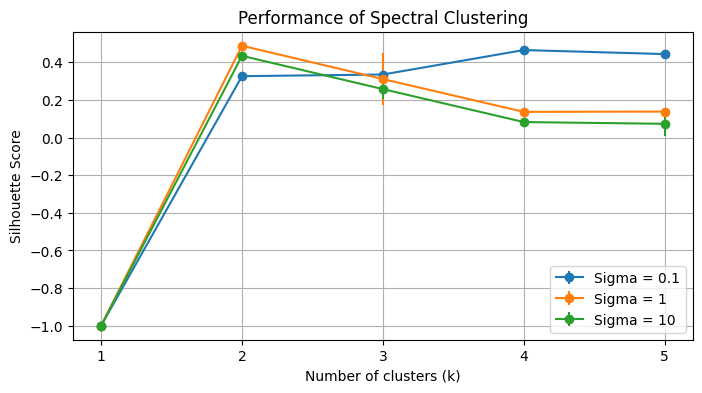

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse.linalg import eigsh        #Imported this library for computation of eigenvalues and eigenvectors.

# Defined a Gaussian similarity function.
def Gaussian_Similarity(X, sigma):
    n = X.shape[0]
    S = np.zeros((n, n))          #Initialized an empty matrix.
    for i in range(n):
        for j in range(n):
            if i != j:
                diff = np.linalg.norm(X[i] - X[j]) #Calculated the euclidean distances.
                S[i, j] = np.exp(-diff**2 / (2. * sigma**2))  # Computed the similarty between data points and stored them in similarity matrix s.
    return S                          

# Computed the  unnormalized Laplacian matrix because it is a fundamental tool for spectral clustering algorithms.
def Unnormalized_Laplacian(W):
    D = np.diag(np.sum(W, axis=1)) #Computed the degree matrix D.
    L = D - W                       #Computing the unnormalised Laplacian matrx L.
    return L

# Defined a function for Spectral Clustering with k number of clusters and sigma as the parameter.
def Spectral_Clustering(X, k, sigma):
    S = Gaussian_Similarity(X, sigma)       #Computed the gaussian similarity matrix S.
    L = Unnormalized_Laplacian(S)          #Computed the unnormalised laplacion matrix L.
    _, eigvecs = eigsh(L, k=k, which='SM') #Computed the k eigenvectors of L.
    U = eigvecs
    kmeans = KMeans(n_clusters=k)            
    labels = kmeans.fit_predict(U)
    return labels

# Defined different  parameters like range of k and sigma values.
k_values = range(1, 6)
sigma_values = [0.1, 1, 10]
results = {sigma: [] for sigma in sigma_values}



# Performed clustering for each sigma and k combination.
for sigma in sigma_values:
    for k in k_values:
        silhouette_scores = []
        if k == 1:
            avg_silhouette = -1  # Placeholder value for k=1.
            std_silhouette = 0
        else:
            for _ in range(10):  # Ran clustering 10 times with different random initializations.
                labels = Spectral_Clustering(X, k, sigma)
                silhouette = silhouette_score(X, labels)
                silhouette_scores.append(silhouette)
            if silhouette_scores:  # Ensured there are valid silhouette scores.
                avg_silhouette = np.mean(silhouette_scores)
                std_silhouette = np.std(silhouette_scores)
        results[sigma].append((k, avg_silhouette, std_silhouette))

# Ploted the graph.
plt.figure(figsize=(8, 4))
for sigma, performance in results.items():
    if performance:  # Checked if there's any valid performance data.
        k_vals, avg_silhouette, std_silhouette = zip(*performance)
        plt.errorbar(k_vals, avg_silhouette, yerr=std_silhouette, label=f'Sigma = {sigma}', fmt='-o')   #You can see the errorbars on some points.
plt.title('Performance of Spectral Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Question -4 : Anomaly detection with the Isolation Forest
Here I implemented the Isolation Forest anomaly detection algorithm as mentioned in the research paper.First I used an Isolation Forest to detect 
anomalies in the dataset, then I removed the anomalies from the dataset.I applied k-means clustering then to the cleande data-set. Then I Evaluated the 
performance of the clustering using silhouetter score.Repeated this process for different percentage of anomalise removed and Finally Plotted a graph 
showing  performance of k-means with k-means++ and k=2 on the data after removing different percentages of anomalies.

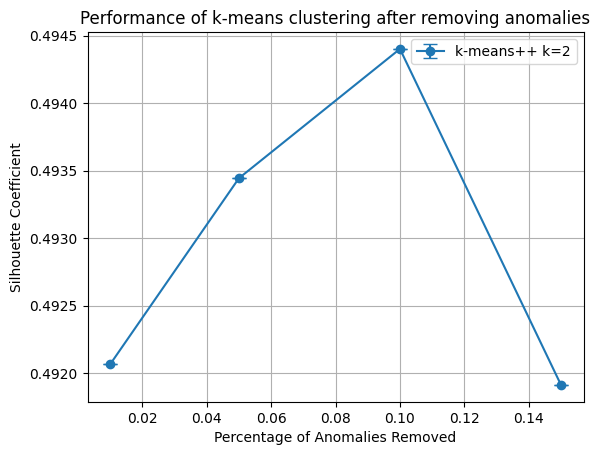

In [39]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#Implemented a class for Isolation Forest for anomaly detection.
class Isolation_Forest:
    def __init__(self, sample_size, n_trees=10):    #Initialized a sample size.
        self.sample_size = sample_size
        self.n_trees = n_trees
        self.trees = []                 #List to store the fittred trees.
        
#Defined a fit function to sample the subsets of data and also to fit an isolation tree for each subset.
    def fit(self, X):
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            idx = np.random.choice(n_samples, self.sample_size, replace=False)
            X_sample = X[idx]
            tree = Isolation_Tree()
            tree.fit(X_sample)               #Fitted the isolation trees to the sample subset.
            self.trees.append(tree)

#Defined this function to calculate the anomaly score of evrey data point by taking average scores of all trees.
    def Anomaly_Score(self, X):
        scores = np.zeros(X.shape[0])   #Initialized an array to store the anomaly scores.
        for tree in self.trees:
            scores += tree.Anomaly_Score(X) #Addes the anomaly score from each tree.
        return scores / self.n_trees     #Returned the average from all trees.

#Defined a class to initalizae a hegiht limit.
class Isolation_Tree:
    def __init__(self, height_limit=np.inf):
        self.height_limit = height_limit         #This is the maximum depth of the tree.
        self.root = None

    #Defined fit function that splits the data and builds the isolation tree.
    def fit(self, X, height=0):
        if height >= self.height_limit or X.shape[0] <= 1:
            return LeafNode(X.shape[0])               #Created a leaf node.

        q = X.shape[1]               #Number of features in the data-set.
        split_attribute = np.random.randint(q)         #Selected a feature randomly to split.
        min_val, max_val = X[:, split_attribute].min(), X[:, split_attribute].max()    #Finded the min and max values of the feature which was selected.
        split_value = min_val + np.random.rand() * (max_val - min_val)     #Randomly split value.

        left_mask = X[:, split_attribute] < split_value #Defined a boolean mask for samples less than the split values.
        right_mask = ~left_mask                           #Same as above but for samples greater than split values.

        left_tree = self.fit(X[left_mask], height + 1)      #Fitted the left sub-tree recursively.
        right_tree = self.fit(X[right_mask], height + 1)     #Same as above but for right sub-tree.

        self.root = InternalNode(split_attribute, split_value, left_tree, right_tree)
        return self.root

    #Defined this function to calcualte the anomaly score of evrey data point based on the depth of the point in the isolation tree.
    def Anomaly_Score(self, X, current_node=None, height=0):
        if current_node is None:
            current_node = self.root          #Starting at the root node.

        if isinstance(current_node, LeafNode):
            return c(current_node.size)

        split_attribute = current_node.split_attribute      # Attributes selected for splitting at the current node.
        split_value = current_node.split_value              #Splitting of attributes at the current node.

        if np.ndim(split_value) == 0:                    # Scalar spliting of  value
            left_mask = X[:, split_attribute] < split_value
        else:                                             # Array used for  splited value
            left_mask = X[:, split_attribute] < split_value[:, np.newaxis]

        return np.where(left_mask,                       #Computed the anomaly scores for samples in the left and right sub-trees.
                        self.Anomaly_Score(X, current_node.left_child, height + 1),
                        self.Anomaly_Score(X, current_node.right_child, height + 1))

#Defined a class for internal node int the isolation tree.
class Internal_Node:
    def __init__(self, split_attribute, split_value, left_child, right_child):
        self.split_attribute = split_attribute
        self.split_value = split_value
        self.left_child = left_child
        self.right_child = right_child

#Defined a clas for leaf node in the isolation tree.
class Leaf_Node:
    def __init__(self, size):
        self.size = size    #This is the number of samples in the subset at the leaf node.

#Defined a function to find the average path lenght of an isolated sample.
def c(n):        
    if n > 2:
        return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n
    elif n == 2:
        return 1
    else:
        return 0
        
# Function to detect anomalies using Isolation Forest
def Detection_of_Anomalies(X, anomaly_percentage):
    n_samples = X.shape[0]
    n_anomalies = int(n_samples * anomaly_percentage)        #Detected the number of anomalies based on the specified percentage.
    ite = Isolation_Forest(sample_size=min(256, n_samples), n_trees=100)
    ite.fit(X)
    Anomaly_Score = ite.Anomaly_Score(X)                #Computed the anomaly scores.
    anomalies_idx = np.argsort(Anomaly_Score)[-n_anomalies:]  #Got the index of all the top anomalies.
    return anomalies_idx

#Defined a  Function to remove anomalies from the data.
def Removing_of_Anomalies(X, anomalies_idx):
    return np.delete(X, anomalies_idx, axis=0)

# DEfined a Function to perform k-means clustering.
def Performance_of_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels

# Defined a Function to evaluate the performance of k-means using Silhouette coefficient.
def Evaluation_of_Performance(X, labels):
    return silhouette_score(X, labels)

# Defined the different anomaly percentages.
anomaly_percentages = [0.01, 0.05, 0.10, 0.15]
kmeans_performance = []

# Looped over each anomaly percentage.
for anomaly_percentage in anomaly_percentages:
    # Detected anomalies using Isolation Forest.
    anomalies_idx = Detection_of_Anomalies(X, anomaly_percentage)
    
    # Removed anomalies from the data-set.
    X_cleaned = Removing_of_Anomalies(X, anomalies_idx)
    
    # Initialized a  list to store silhouette scores for k-means.
    silhouette_scores = []
    
    # Ran k-means 10 times with different initializations.
    for _ in range(10):
        labels = Performance_of_kmeans(X_cleaned, n_clusters=2)
        silhouette_scores.append(Evaluation_of_Performance(X_cleaned, labels))
    
    # Computed mean and standard deviation of silhouette scores.
    mean_score = np.mean(silhouette_scores)
    std_dev = np.std(silhouette_scores)
    
    # Appended mean and standard deviation to kmeans_performance list.
    kmeans_performance.append((mean_score, std_dev))

# Plotted a graph .
plt.errorbar(anomaly_percentages, [score[0] for score in kmeans_performance], yerr=[score[1] for score in kmeans_performance], fmt='-o', capsize=5, label='k-means++ k=2')
plt.xlabel('Percentage of Anomalies Removed')
plt.ylabel('Silhouette Coefficient')
plt.title('Performance of k-means clustering after removing anomalies')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#References:
1. https://youtu.be/_jg1UFoef1c?si=0S3_zJZEVZjBpFDA
2.https://youtu.be/kN--TRv1UDY?si=enEXItmlYnfsNT7S

In [2]:
!pip install nbconvert[webpdf]

   ---------------------------------------- 0.0/29.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/29.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/29.7 MB 653.6 kB/s eta 0:00:46
   ---------------------------------------- 0.3/29.7 MB 2.5 MB/s eta 0:00:12
   - -------------------------------------- 1.4/29.7 MB 9.0 MB/s eta 0:00:04
   --- ------------------------------------ 2.6/29.7 MB 12.9 MB/s eta 0:00:03
   ----- ---------------------------------- 4.0/29.7 MB 15.9 MB/s eta 0:00:02
   ------- -------------------------------- 5.4/29.7 MB 18.2 MB/s eta 0:00:02
   --------- ------------------------------ 6.7/29.7 MB 19.4 MB/s eta 0:00:02
   ----------- ---------------------------- 8.6/29.7 MB 22.1 MB/s eta 0:00:01
   -------------- ------------------------- 10.6/29.7 MB 31.2 MB/s eta 0:00:01
   ---------------- ----------------------- 12.3/29.7 MB 34.4 MB/s eta 0:00:01
   ------------------- -------------------- 14.7/29.7 MB 38.6 MB/s eta 0:00:01
